# Analysis of travel behavior

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from dotenv import load_dotenv
import sql_functions as sf

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#plot Style
sns.set_style("whitegrid")
sns.set_palette('tab10')

### Import dataframes from postgres

In [159]:
# enter the schema name for your course
schema = 'capstone_travel_index'

df_env = sf.get_dataframe(f'SELECT * FROM {schema}.df_env_scr')
df_gov = sf.get_dataframe(f'SELECT * FROM {schema}.df_gov_scr')
df_soc = sf.get_dataframe(f'SELECT * FROM {schema}.df_soc_scr')
df_lgb = sf.get_dataframe(f'SELECT * FROM {schema}.df_lgb_scr')
df_arr = sf.get_dataframe(f'SELECT iso3, year, africa, americas, east_asia_and_the_pacific, europe, middle_east, other_not_classified, south_asia, total FROM {schema}.arrival_regions')
df_price = sf.get_dataframe(f'SELECT * FROM {schema}.city_prices_final')
df_regions = sf.get_dataframe(f'SELECT * FROM {schema}.world_regions')

In [160]:
print(df_env.info())
print(df_gov.info())
print(df_soc.info())
print(df_lgb.info())
print(df_price.info())
print(df_regions.info())
print(df_arr.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   iso3       1930 non-null   object        
 1   year       1930 non-null   datetime64[ns]
 2   env_score  1930 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 45.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   iso3       1930 non-null   object        
 1   year       1930 non-null   datetime64[ns]
 2   gov_score  1930 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 45.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------

In [161]:
print(df_env.head())
print(df_gov.head())
print(df_gov.head())
print(df_lgb.head())
print(df_price.head())
print(df_arr.head())

  iso3       year  env_score
0  AFG 2012-01-01   0.492424
1  AFG 2013-01-01   0.606061
2  AFG 2014-01-01   0.813309
3  AFG 2015-01-01   1.054545
4  AFG 2016-01-01   1.152482
  iso3       year  gov_score
0  AFG 2012-01-01   1.224490
1  AFG 2013-01-01   1.134969
2  AFG 2014-01-01   1.277719
3  AFG 2015-01-01   1.078749
4  AFG 2016-01-01   1.041890
  iso3       year  gov_score
0  AFG 2012-01-01   1.224490
1  AFG 2013-01-01   1.134969
2  AFG 2014-01-01   1.277719
3  AFG 2015-01-01   1.078749
4  AFG 2016-01-01   1.041890
  iso3       year  lgb_score
0  AFG 2012-01-01   2.173913
1  AFG 2013-01-01   2.173913
2  AFG 2014-01-01   2.173913
3  AFG 2015-01-01   2.173913
4  AFG 2016-01-01   2.173913
       city iso3          1          3         4         7        13  \
0    Aachen  DEU  10.000000   9.000000  3.500000  2.225000  0.496250   
1   Aalborg  DNK  17.457899  13.160570  6.647431  2.366888  1.692073   
2  Aberdeen  GBR  17.419919   6.613763  4.238847  1.177918  1.010355   
3   Abidjan  CIV

**Create Total Column for prices**

In [162]:
df_price.columns

Index(['city', 'iso3', '1', '3', '4', '7', '13', '18', '26', '108', '114'], dtype='object')

In [163]:
df_price.head()

,city,iso3,1,3,4,7,13,18,26,108,114
0,Aachen,DEU,10.000000,9.000000,3.500000,2.225000,0.496250,2.950000,72.800630,5.850000,2.885714
1,Aalborg,DNK,17.457899,13.160570,6.647431,2.366888,1.692073,3.222997,94.279686,6.647431,4.521148
2,Aberdeen,GBR,17.419919,6.613763,4.238847,1.177918,1.010355,3.483984,83.189090,4.773058,3.440434
3,Abidjan,CIV,3.048981,8.384696,1.410153,0.727598,0.662391,0.609796,63.695462,4.573471,2.429656
4,Accra,GHA,3.211588,5.821003,0.802897,0.228517,0.418653,0.433564,88.335173,2.925540,1.962515


In [164]:
df_price['price_total'] = df_price.iloc[:, 2:].sum(axis=1)
df_price

,city,iso3,1,3,4,7,13,18,26,108,114,price_total
0,Aachen,DEU,10.000000,9.000000,3.500000,2.225000,0.496250,2.950000,72.800630,5.850000,2.885714,109.707594
1,Aalborg,DNK,17.457899,13.160570,6.647431,2.366888,1.692073,3.222997,94.279686,6.647431,4.521148,149.996122
2,Aberdeen,GBR,17.419919,6.613763,4.238847,1.177918,1.010355,3.483984,83.189090,4.773058,3.440434,125.347369
3,Abidjan,CIV,3.048981,8.384696,1.410153,0.727598,0.662391,0.609796,63.695462,4.573471,2.429656,85.542204
4,Accra,GHA,3.211588,5.821003,0.802897,0.228517,0.418653,0.433564,88.335173,2.925540,1.962515,104.139451
...,...,...,...,...,...,...,...,...,...,...,...,...
533,Yerevan,ARM,8.276290,7.093963,1.418793,0.493382,0.589193,0.236465,128.895067,0.709396,2.975579,150.688130
534,Zadar,HRV,7.995606,6.647361,2.643390,1.855413,0.941075,1.595367,55.076038,3.212657,1.691879,81.658785
535,Zagreb,HRV,10.606940,7.296962,2.659200,1.737198,1.021138,0.566386,78.444354,2.388272,1.976139,106.696587
536,Zaragoza (Saragossa),ESP,12.000000,7.500000,2.500000,1.471429,0.541250,1.400000,81.852083,2.460000,1.657143,111.381905


In [165]:
df_price[df_price['iso3'] == 'DEU'].mean()

1               12.885417
3                9.184167
4                4.118750
7                2.240146
13               0.585366
18               2.942708
26             106.502469
108              6.392122
114              3.116530
price_total    147.967674
dtype: float64

**Calculate the Average price for each country**

In [166]:
df_price_un = pd.DataFrame(df_price.groupby('iso3')['price_total'].mean().reset_index())
df_price_un

,iso3,price_total
0,ALB,87.578086
1,ARE,164.692212
2,ARG,75.313050
3,ARM,150.688130
4,AUS,247.235734
...,...,...
127,VEN,66.123340
128,VNM,59.767783
129,XKX,59.461667
130,ZAF,92.194622


In [167]:
df_price_un['iso3'].nunique()

132

### Create Datafram with all the scores and travel data

In [168]:
df_analysis = pd.merge(df_env, df_gov, on=['iso3', 'year'], how='left')
df_analysis = pd.merge(df_analysis, df_soc, on=['iso3', 'year'], how='left')
df_analysis = pd.merge(df_analysis, df_lgb, on=['iso3', 'year'], how='left')
df_analysis = pd.merge(df_analysis, df_arr, on=['iso3', 'year'], how='left')
df_analysis = pd.merge(df_analysis, df_regions, on=['iso3'], how='left')
df_analysis = pd.merge(df_analysis, df_price_un, on=['iso3'], how='left')

In [169]:
df_analysis.head()

,iso3,year,env_score,gov_score,soc_score,lgb_score,africa,americas,east_asia_and_the_pacific,europe,middle_east,other_not_classified,south_asia,total,sub-region_name,price_total
0,AFG,2012-01-01,0.492424,1.224490,4.038997,2.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,NaN
1,AFG,2013-01-01,0.606061,1.134969,4.186352,2.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,NaN
2,AFG,2014-01-01,0.813309,1.277719,4.809461,2.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,NaN
3,AFG,2015-01-01,1.054545,1.078749,4.152431,2.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,NaN
4,AFG,2016-01-01,1.152482,1.041890,4.961240,2.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,NaN


In [170]:
df_analysis.shape

(1930, 16)

In [171]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1930 entries, 0 to 1929
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   iso3                       1930 non-null   object        
 1   year                       1930 non-null   datetime64[ns]
 2   env_score                  1930 non-null   float64       
 3   gov_score                  1930 non-null   float64       
 4   soc_score                  1930 non-null   float64       
 5   lgb_score                  1764 non-null   float64       
 6   africa                     1380 non-null   float64       
 7   americas                   1660 non-null   float64       
 8   east_asia_and_the_pacific  1550 non-null   float64       
 9   europe                     1670 non-null   float64       
 10  middle_east                1150 non-null   float64       
 11  other_not_classified       1180 non-null   float64       
 12  south_

**Selecting the Years**

In [173]:
# Select specific years
sel_years = ['2012-01-01', 
             '2013-01-01', 
             '2014-01-01', 
             '2015-01-01', 
             '2016-01-01', 
             '2017-01-01', 
             '2018-01-01', 
             '2019-01-01']

# Filter the DataFrame based on the selected years
df_analysis = df_analysis[df_analysis['year'].isin(sel_years)]

**Calculate the total Score**

In [124]:

df_analysis['total_score'] = ((df_analysis['env_score'] 
                            + df_analysis['gov_score'] 
                            + df_analysis['soc_score']
                            + df_analysis['lgb_score']) / 4)

In [156]:
df_analysis.shape

(1544, 18)

## EDA

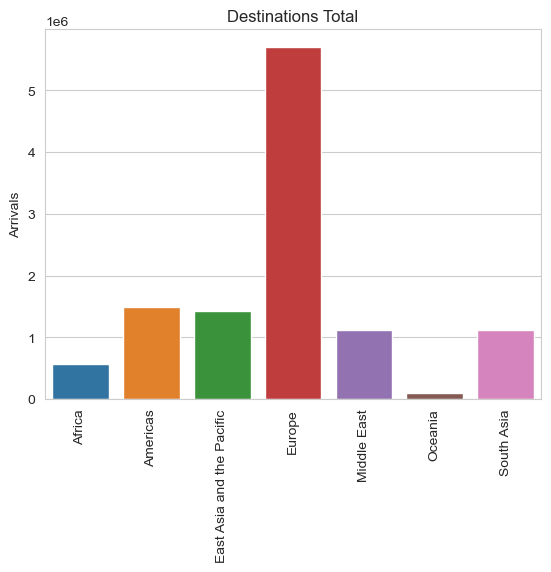

In [178]:
# Group the data by 'sub-region_name' and calculate the sum of 'total'
total_arrival_reg = df_analysis.groupby('sub-region_name')['total'].sum()

# Reset the index to include 'sub-region_name' as a column
total_arrival_reg = total_arrival_reg.reset_index()

# Plot the bar plot using seaborn
sns.barplot(x='sub-region_name', y='total', data=total_arrival_reg)

# Add labels and title to the plot
plt.xlabel('')
plt.ylabel('Arrivals')
plt.title('Destinations Total')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()

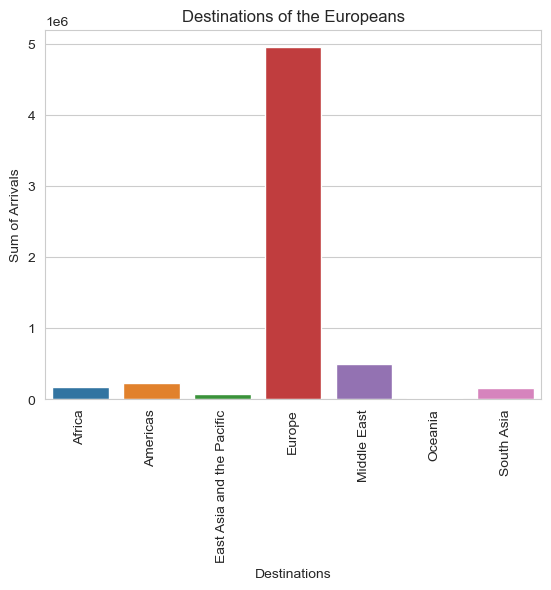

In [179]:
# Group the data by 'sub-region_name' and calculate the sum of the desired columns
arrival_from_eu = df_analysis.groupby('sub-region_name').sum()['europe']

# Reset the index to include 'sub-region_name' as a column
arrival_from_eu = arrival_from_eu.reset_index()

# Plot the bar chart using seaborn
sns.barplot(x='sub-region_name', y='europe', data=arrival_from_eu)

# Add labels and a title to the plot
plt.xlabel('Destinations')
plt.ylabel('Sum of Arrivals')
plt.title('Destinations of the Europeans')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()


<Figure size 1000x600 with 0 Axes>

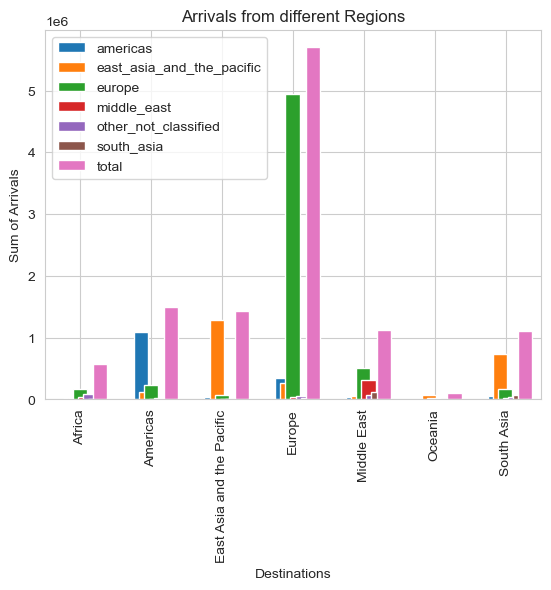

In [180]:
# Group the data by 'sub-region_name' and calculate the sum of the desired columns
arr_dest_total = df_analysis.groupby('sub-region_name')[['americas', 'east_asia_and_the_pacific', 'europe',
                                              'middle_east', 'other_not_classified', 'south_asia', 'total']].sum()


# Adjust the figure size
plt.figure(figsize=(10, 6))  # Modify the width and height as needed

# Plot the bar chart
ax = arr_dest_total.plot.bar()

# Adjust the width of the bars
bar_width = 0.2  # Modify the width as needed
for container in ax.containers:
    plt.setp(container, width=bar_width)

# Add labels and a title to the plot
plt.xlabel('Destinations')
plt.ylabel('Sum of Arrivals')
plt.title('Arrivals from different Regions')

# Display the plot
plt.show()

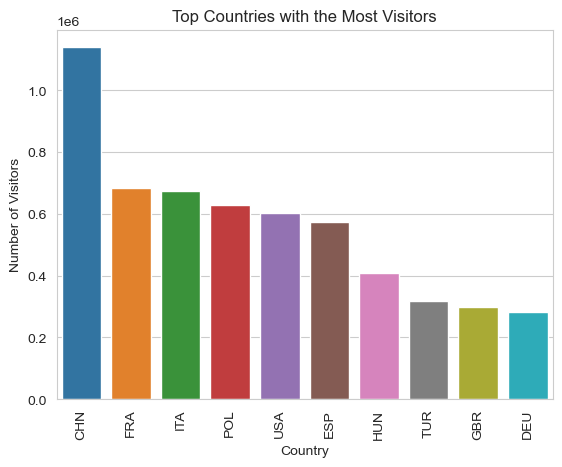

In [128]:
# Sort the DataFrame based on the 'total' column in descending order
sorted_df = df_analysis.groupby('iso3')['total'].sum().sort_values(ascending=False)

# Filter the DataFrame to include only the top countries with the most visitors
top_countries_df = sorted_df.head(10)

# Create a bar plot using seaborn
sns.barplot(x=top_countries_df.index, y=top_countries_df.values)

# Add labels and a title to the plot
plt.xlabel('Country')
plt.ylabel('Number of Visitors')
plt.title('Top Countries with the Most Visitors')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()

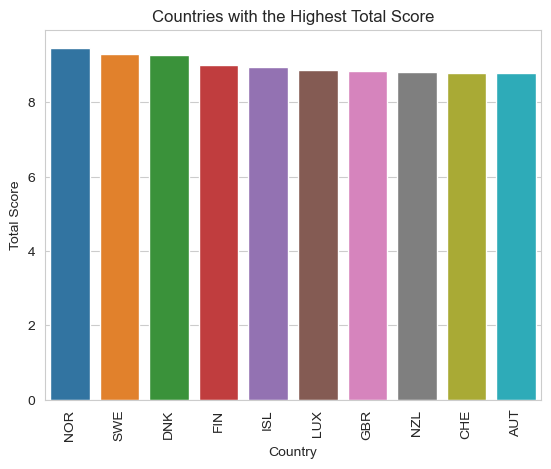

In [129]:
# Sort the DataFrame based on the 'total' column in descending order
sorted_score_df = df_analysis.groupby('iso3')['total_score'].mean().sort_values(ascending=False)

# Filter the DataFrame to include only the top countries with the most visitors
top_score_df = sorted_score_df.head(10)

# Create a bar plot using seaborn
sns.barplot(x=top_score_df.index, y=top_score_df.values)

# Add labels and a title to the plot
plt.xlabel('Country')
plt.ylabel('Total Score')
plt.title('Countries with the Highest Total Score')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()

In [130]:
# Create a new column 'rest_of_world' as the sum of scores from regions other than Europe
df_analysis['rest_of_world'] = df_analysis[['africa', 'americas', 'east_asia_and_the_pacific', 'middle_east', 'other_not_classified',
                          'south_asia']].sum(axis=1)

In [108]:
df_analysis[['env_score', 'gov_score','soc_score', 'lgb_score', 'total_score', 'price_total', 'total']].describe()

,env_score,gov_score,soc_score,lgb_score,total_score,price_total,total
count,1544.000000,1544.000000,1544.000000,1404.000000,1404.000000,984.000000,1336.000000
mean,4.438760,5.140768,5.993640,5.055333,5.276051,108.326308,8622.223802
std,2.352880,2.332014,2.132932,2.142719,1.840763,71.041840,18553.029573
min,0.000000,0.000000,0.000000,0.000000,0.028409,0.304898,24.000000
25%,2.658586,3.392511,4.300662,3.478261,3.950374,59.074941,596.500000
50%,4.188219,4.919268,6.795796,4.782609,5.173435,88.597483,1993.000000
75%,6.122815,6.860999,7.676444,6.400000,6.459194,149.021560,7655.500000
max,10.000000,10.000000,10.000000,10.000000,9.614567,362.101969,162538.000000


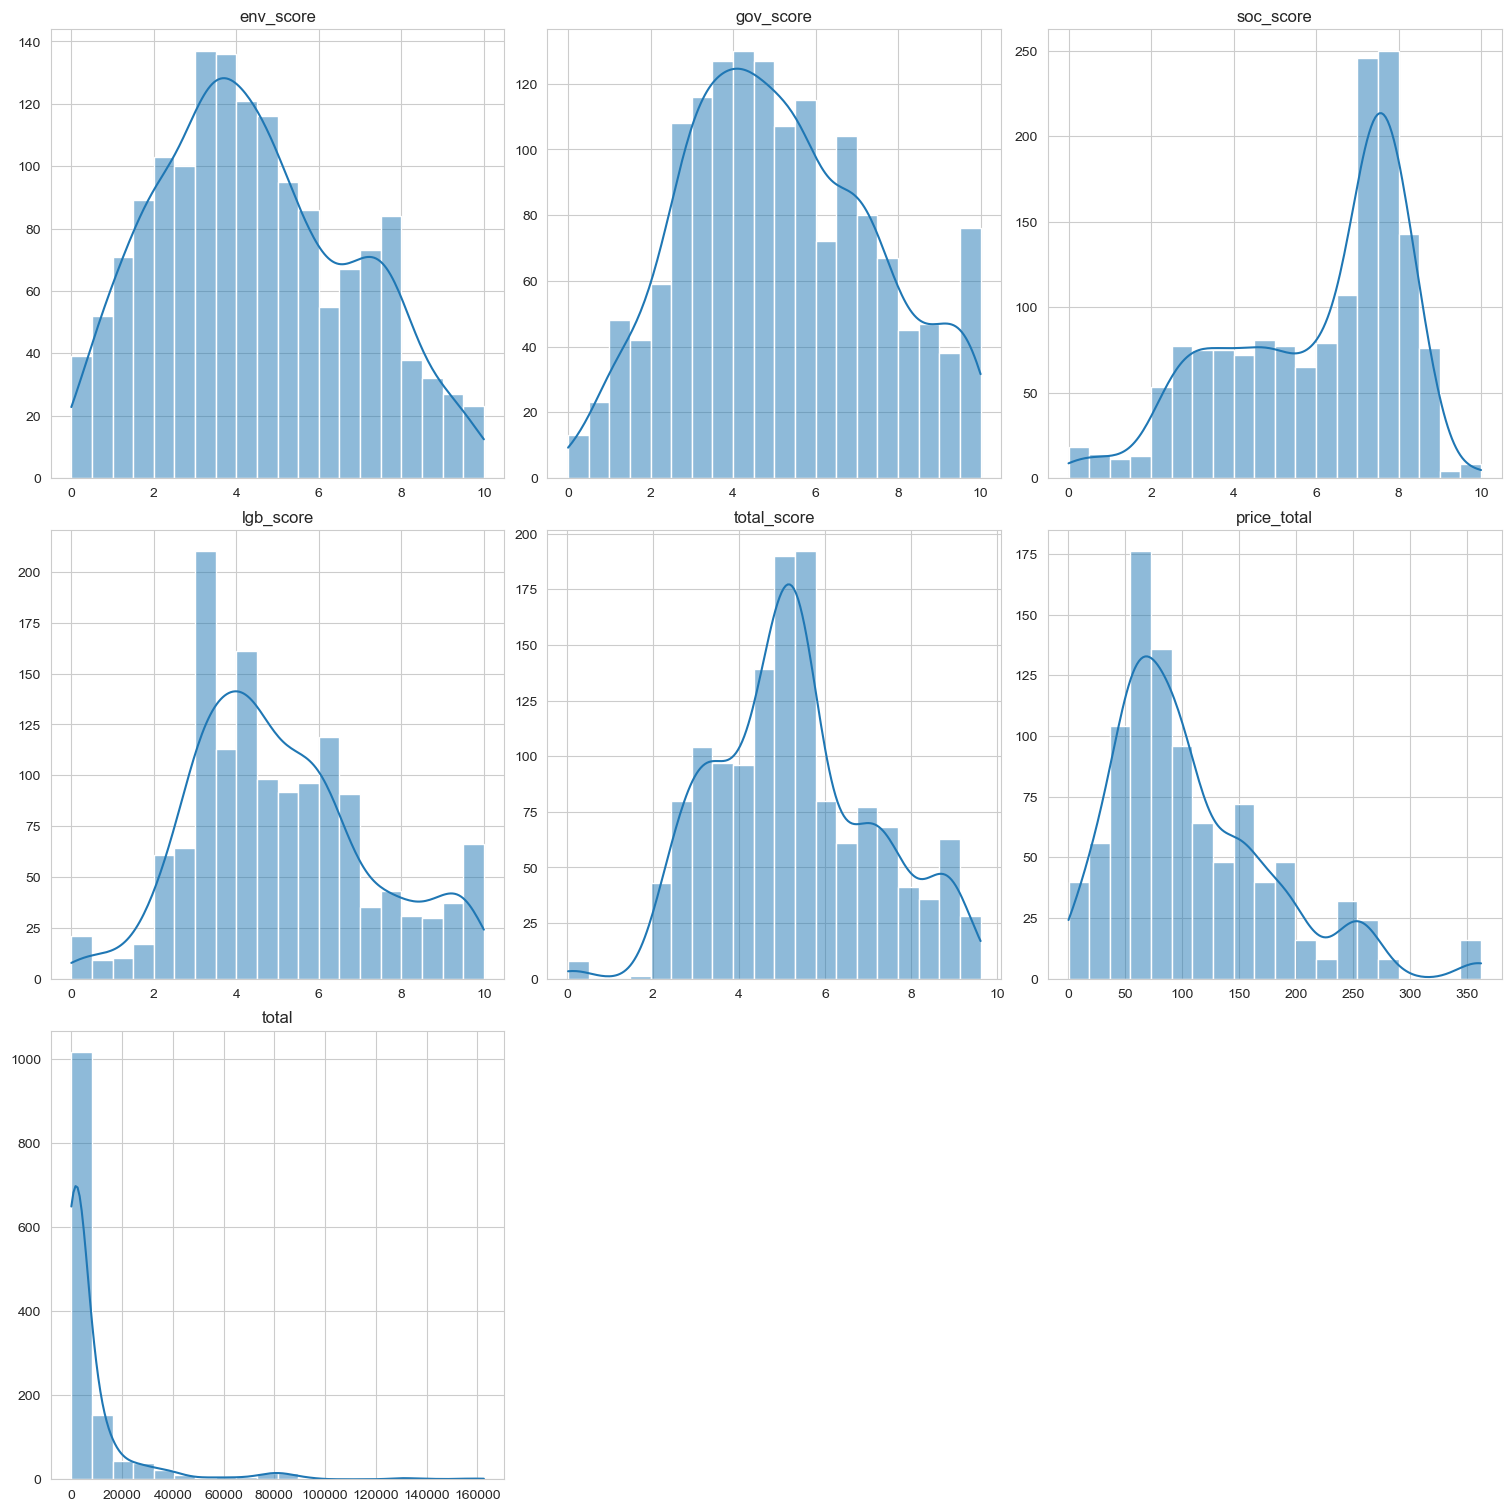

In [132]:
num_col = ['env_score', 'gov_score','soc_score', 'lgb_score', 'total_score', 'price_total', 'total']
rows, cols = 3, 3
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in num_col:
    plt.subplot(rows, cols, counter)
    sns.histplot(data = df_analysis, x= i, bins=20, kde=True)
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

In [133]:
# Apply logarithmic transformation to the travel data
df_log = df_analysis.copy()
colum_to_log = ['africa', 'americas', 'east_asia_and_the_pacific', 'europe', 'middle_east', 'other_not_classified', 'south_asia', 'total']
df_log[colum_to_log] = df_log[colum_to_log].apply(lambda x: np.log(x))

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


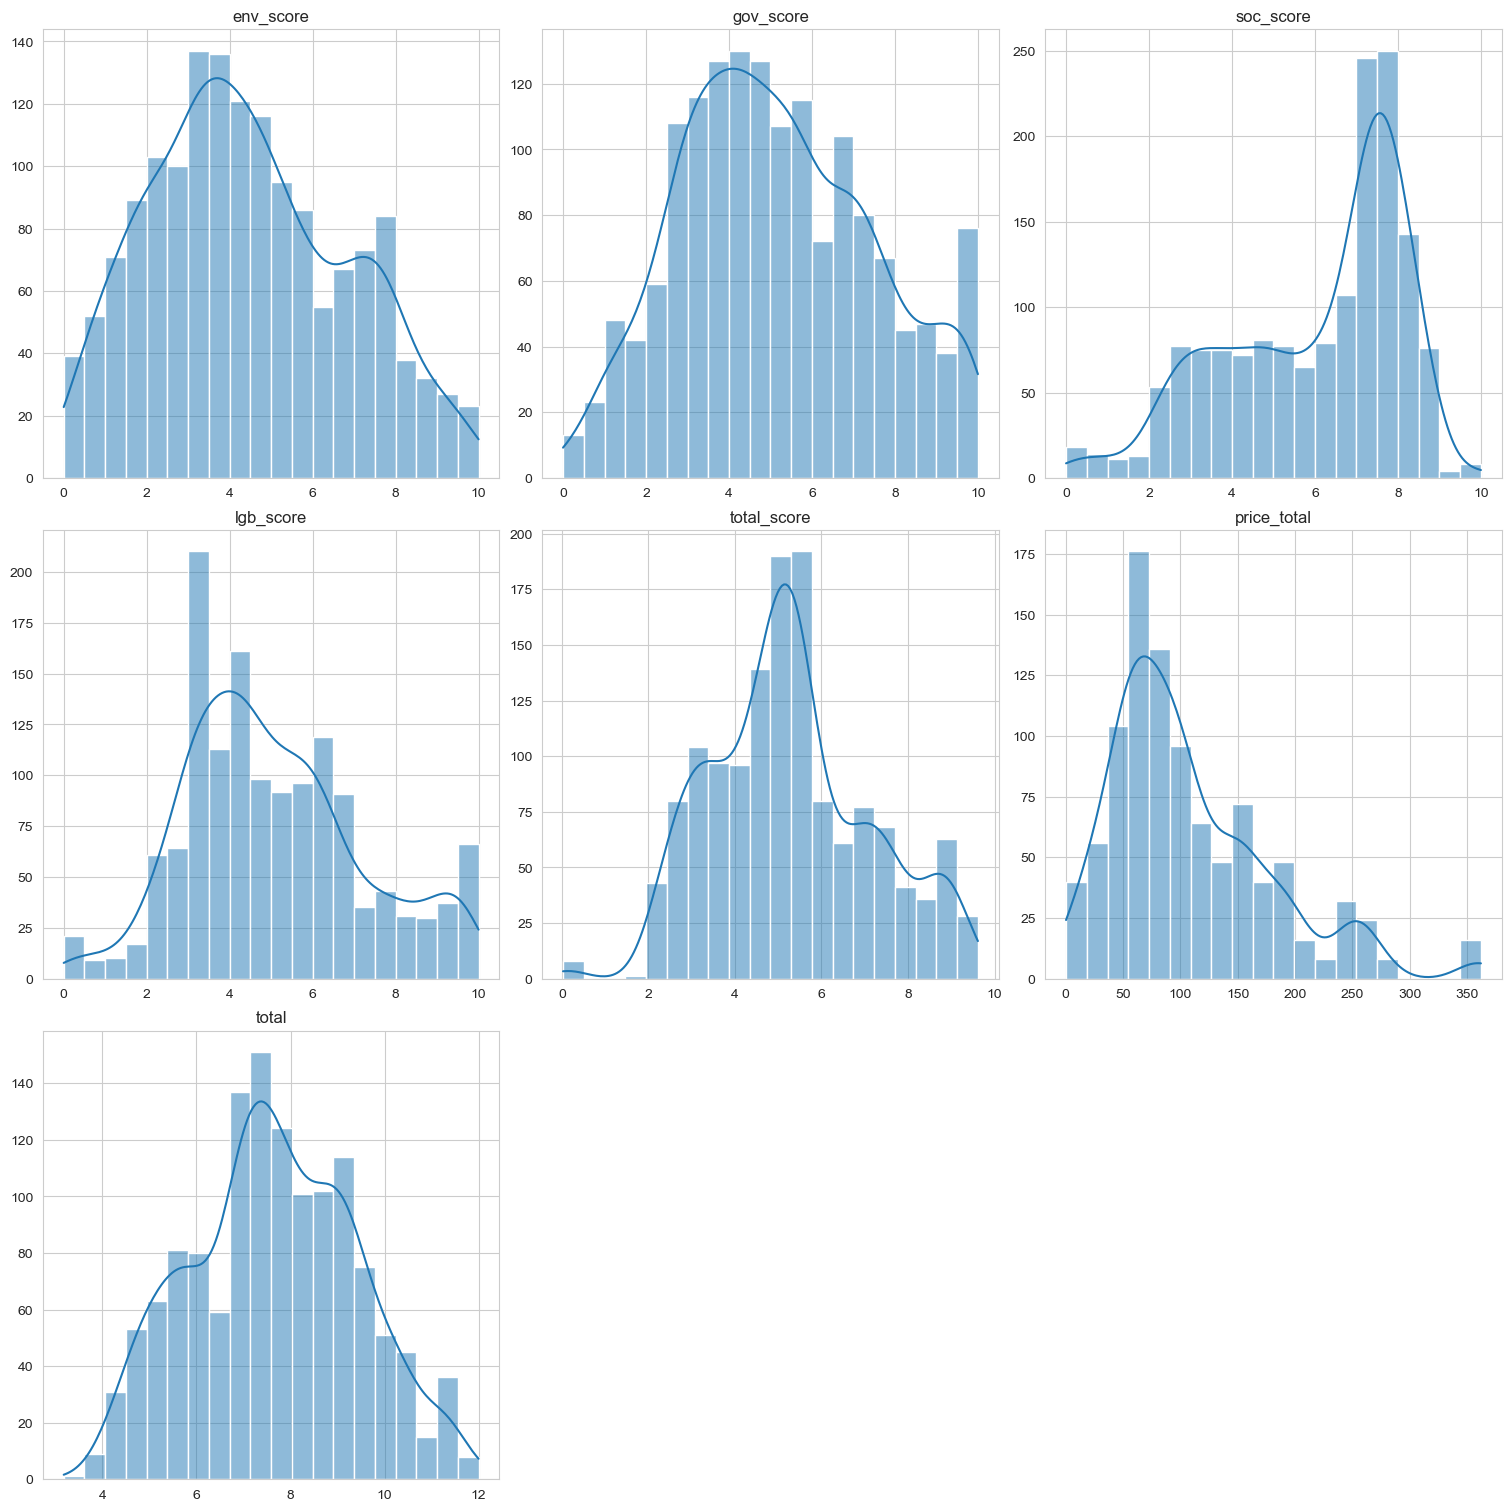

In [134]:
num_col = ['env_score', 'gov_score','soc_score', 'lgb_score', 'total_score', 'price_total', 'total']
rows, cols = 3, 3
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in num_col:
    plt.subplot(rows, cols, counter)
    sns.histplot(data = df_log, x= i, bins=20, kde=True)
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

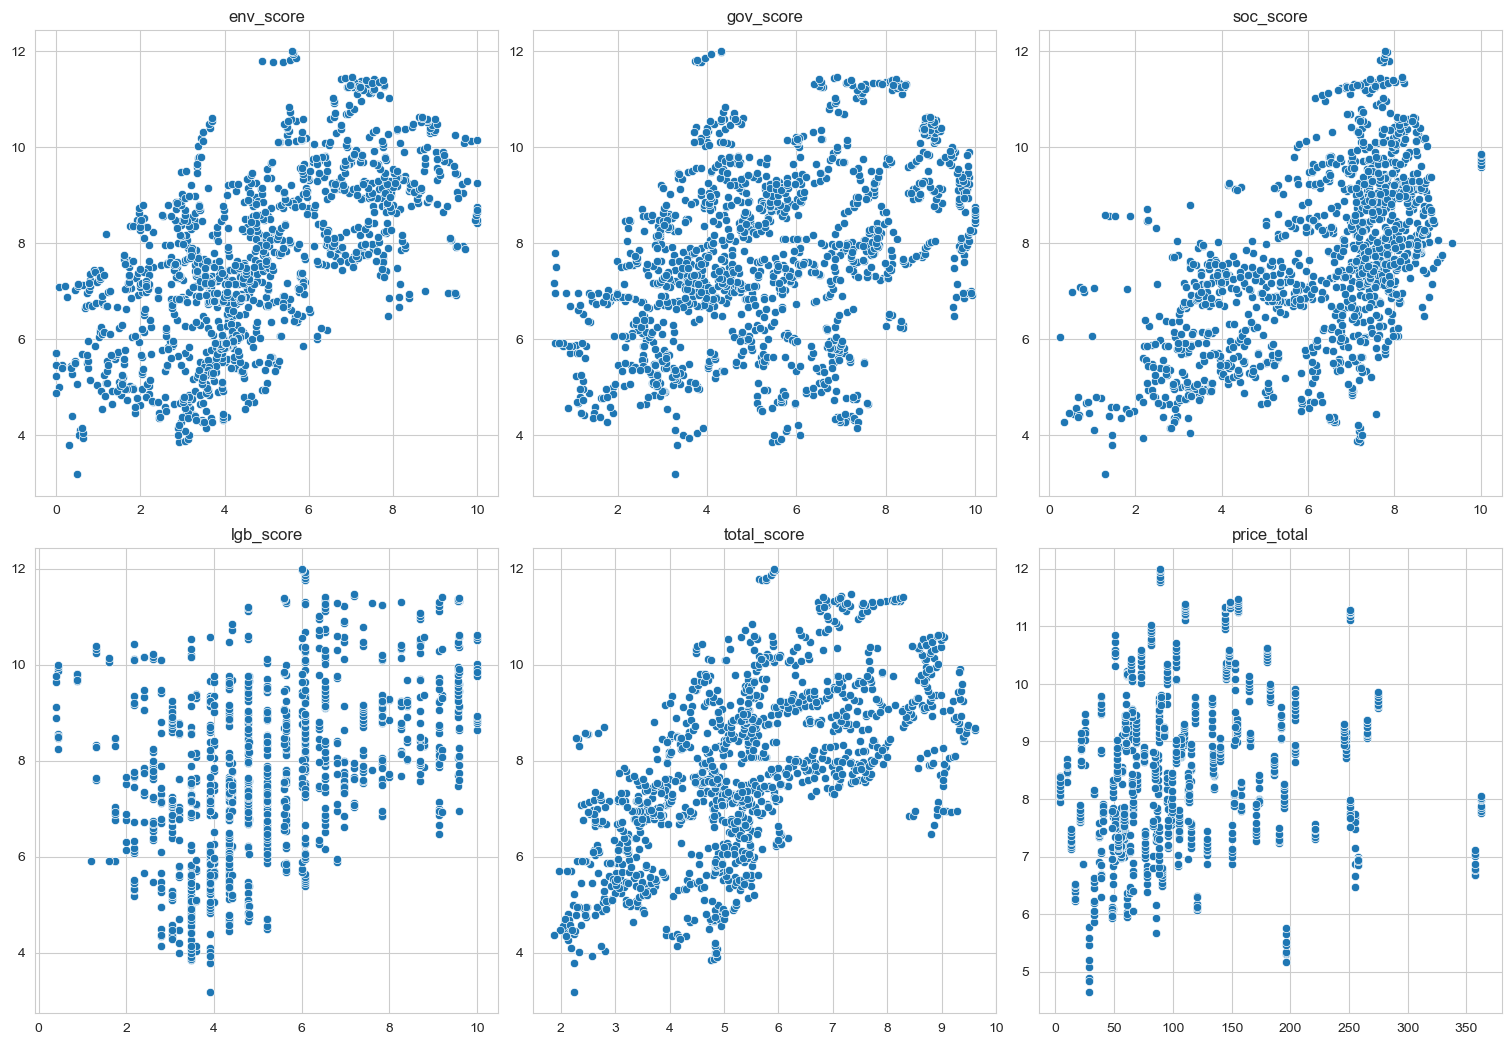

In [135]:
score_col = ['env_score', 'gov_score','soc_score', 'lgb_score', 'total_score', 'price_total']
rows, cols = 3, 3
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in score_col:
    plt.subplot(rows, cols, counter)
    sns.scatterplot(data = df_log, x= i,y='total')
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

### Correlation Matrix and Heatmap

https://stackoverflow.com/questions/57155427/how-does-corr-remove-na-and-null-values

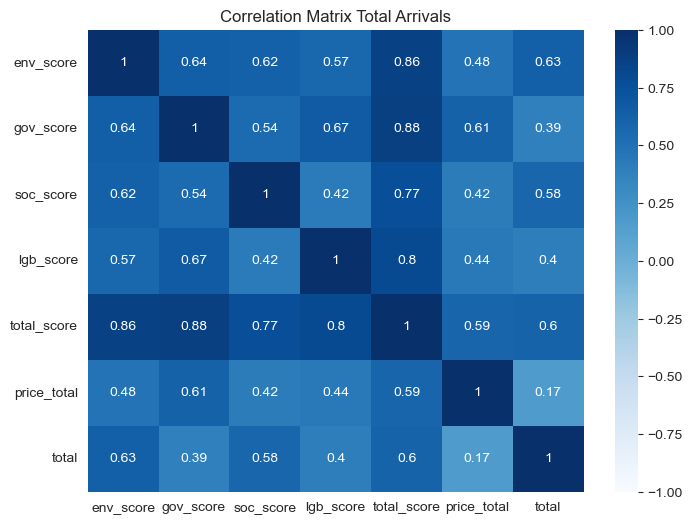

In [136]:
# Compute the correlation matrix
corr_matrix = df_log[['env_score', 'gov_score', 'soc_score', 'lgb_score', 'total_score', 'price_total', 'total']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Total Arrivals')
plt.show()

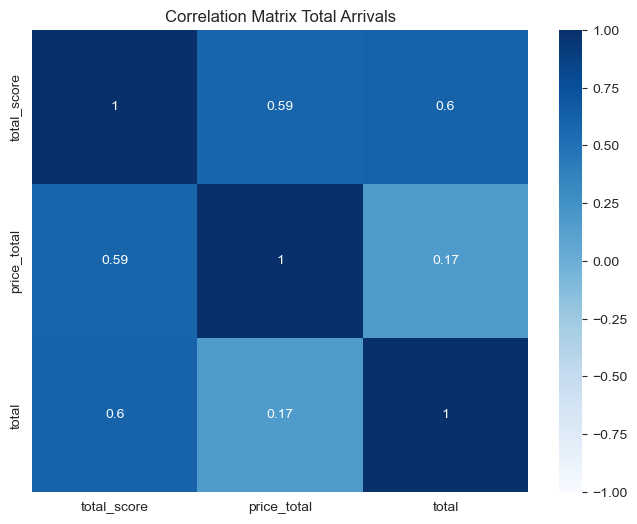

In [181]:
# Compute the correlation matrix
corr_matrix = df_log[['total_score', 'price_total', 'total']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Total Arrivals')
plt.show()

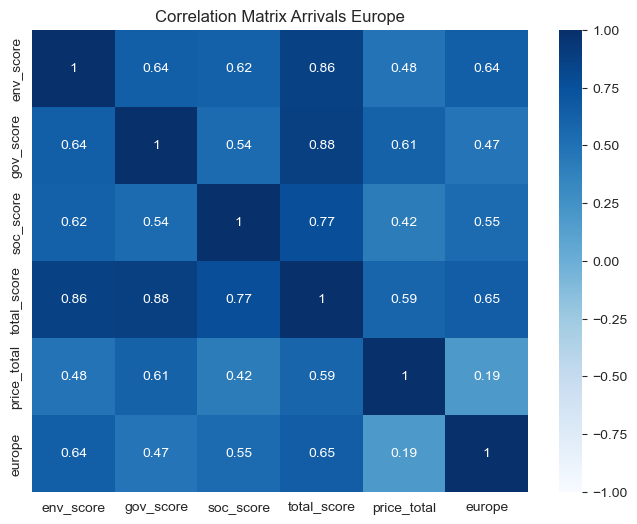

In [137]:
# Compute the correlation matrix
corr_matrix = df_log[['env_score', 'gov_score', 'soc_score', 'total_score', 'price_total', 'europe']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Arrivals Europe')
plt.show()

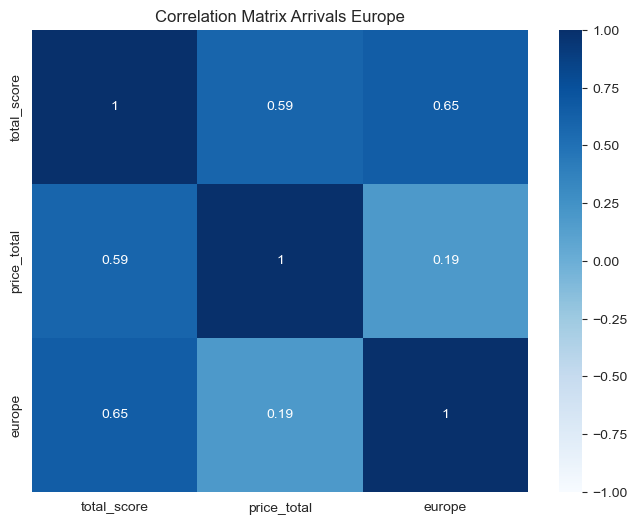

In [182]:
# Compute the correlation matrix
corr_matrix = df_log[['total_score', 'price_total', 'europe']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Arrivals Europe')
plt.show()

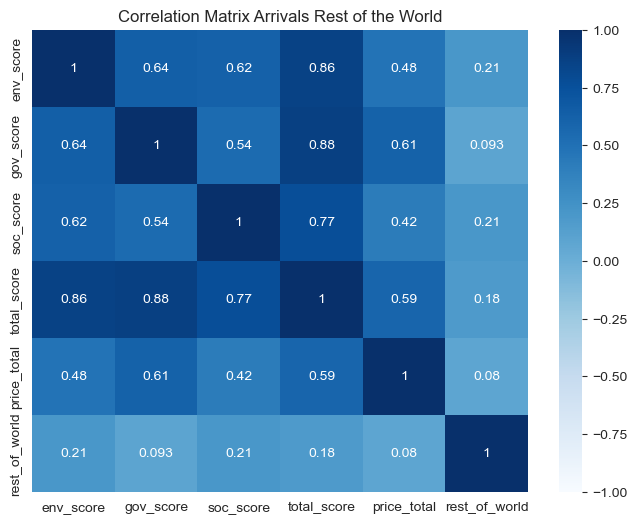

In [138]:
# Compute the correlation matrix
corr_matrix = df_log[['env_score', 'gov_score', 'soc_score', 'total_score', 'price_total', 'rest_of_world']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Arrivals Rest of the World')
plt.show()

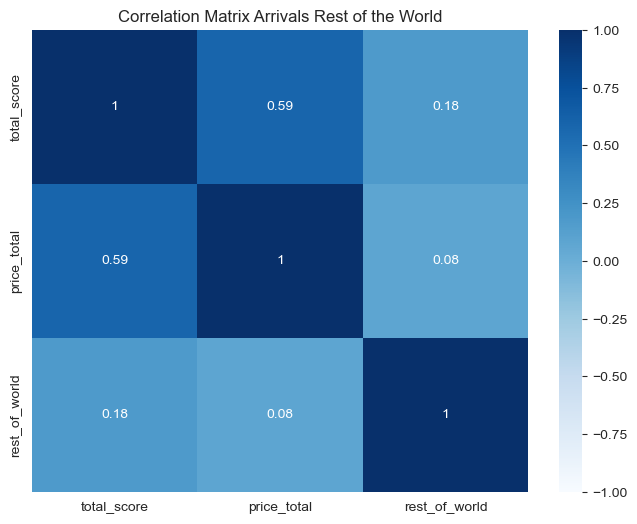

In [184]:
# Compute the correlation matrix
corr_matrix = df_log[['total_score', 'price_total', 'rest_of_world']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Arrivals Rest of the World')
plt.show()

In [139]:
# Filter the DataFrame to include only countries in the 'Europe' sub-region
europe_df = df_log[df_analysis['sub-region_name'] == 'Europe']

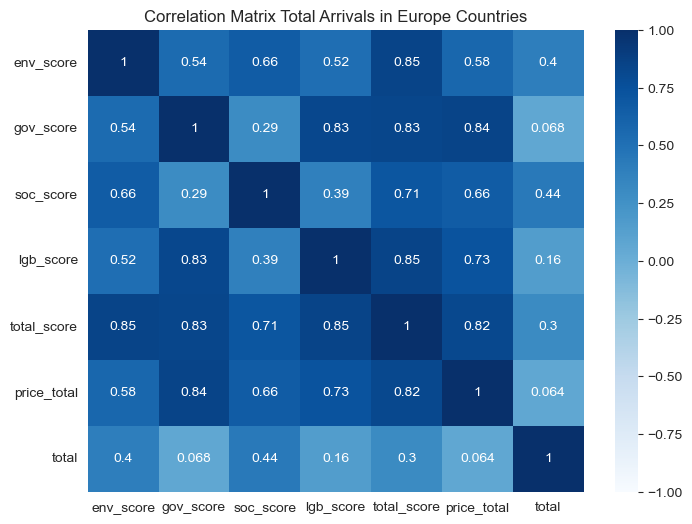

In [140]:
# Compute the correlation matrix
corr_matrix = europe_df[['env_score', 'gov_score', 'soc_score', 'lgb_score', 'total_score', 'price_total', 'total']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Total Arrivals in Europe Countries')
plt.show()

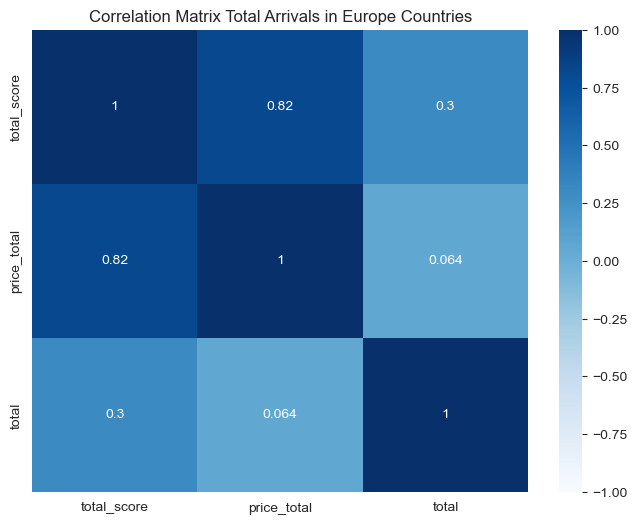

In [185]:
# Compute the correlation matrix
corr_matrix = europe_df[['total_score', 'price_total', 'total']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Total Arrivals in Europe Countries')
plt.show()

The correlation coefficient of 0.3 suggests a moderate indicates a positive relationship between tourist numbers and environmental score. It is not extremely strong but still indicates a discernible association.

### Simple linear regression

In [141]:
# Import the statsmodels module
import statsmodels.api as sm

In [142]:
# Prepare data for modeling
df_lin_reg = df_log.dropna()
# Choose the predictor X and add a constant term
X = df_lin_reg[['total_score']]
# Our model needs an intercept so we add a column of 1s:
X = sm.add_constant(X)
# Define dependent variable
y = df_lin_reg['total']

In [143]:
# Create an OLS model
model = sm.OLS(y, X)
# use the data to calculate the intercept and slope
results = model.fit()
# return the output of the model
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     116.1
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           1.82e-24
Time:                        09:30:24   Log-Likelihood:                -781.69
No. Observations:                 496   AIC:                             1567.
Df Residuals:                     494   BIC:                             1576.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.6495      0.195     34.076      0.000       6.266       7.033
total_score     0.3479      0.032     10.777      0.000       0.284       0.411
==============================================================================
Omnibus:                       15.410   Durbin-Watson:                   0.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.785
Skew:                           0.378   Prob(JB):                     0.000616
Kurtosis:                       2.622   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [144]:
europe_df
# Prepare data for modeling
df_eu_lin_reg = europe_df.dropna()
# Choose the predictor X and add a constant term
Xe = df_eu_lin_reg[['total_score']]
# Our model needs an intercept so we add a column of 1s:
Xe = sm.add_constant(Xe)
# Define dependent variable
y = df_eu_lin_reg['total']

In [145]:
# Create an OLS model
model = sm.OLS(y, Xe)
# use the data to calculate the intercept and slope
results = model.fit()
# return the output of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     17.26
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           5.59e-05
Time:                        09:30:35   Log-Likelihood:                -243.05
No. Observations:                 144   AIC:                             490.1
Df Residuals:                     142   BIC:                             496.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.0268      0.521     13.481      0.000       5.996       8.057
total_score     0.3028      0.073      4.155      0.000       0.159       0.447
==============================================================================
Omnibus:                       25.747   Durbin-Watson:                   0.323
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.454
Skew:                           0.063   Prob(JB):                       0.0397
Kurtosis:                       1.971   Cond. No.                         34.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Change over Years

### Create a DataFrame with the differenz from 2012 to 2019

In [146]:
change_years = ['2012-01-01',
                '2019-01-01']

# Filter the DataFrame based on the selected years
df_analysis_change = df_analysis[df_analysis['year'].isin(change_years)]


In [147]:
#Create a new dataframe with the desired columns:
iso3_codes = df_analysis_change['iso3'].unique()
df_analysis_diff = pd.DataFrame(columns=['iso3', 'env_score_diff', 'gov_score_diff', 'soc_score_diff', 'lgb_score_diff', 'total_score_diff', 'total_diff'])


for iso3 in iso3_codes:
    iso3_rows = df_analysis_change[df_analysis_change['iso3'] == iso3]


    if len(iso3_rows) == 2:
        row_2012 = iso3_rows[iso3_rows['year'] == '2012-01-01']
        row_2019 = iso3_rows[iso3_rows['year'] == '2019-01-01']
        
        env_score_diff = row_2019['env_score'].values[0] - row_2012['env_score'].values[0]
        gov_score_diff = row_2019['gov_score'].values[0] - row_2012['gov_score'].values[0]
        soc_score_diff = row_2019['soc_score'].values[0] - row_2012['soc_score'].values[0]
        lgb_score_diff = row_2019['lgb_score'].values[0] - row_2012['lgb_score'].values[0]
        total_score_diff = row_2019['total_score'].values[0] - row_2012['total_score'].values[0]
        total_diff = row_2019['total'].values[0] - row_2012['total'].values[0]
        
        new_row = {'iso3': iso3, 'env_score_diff': env_score_diff, 'gov_score_diff': gov_score_diff,
                   'soc_score_diff': soc_score_diff, 'lgb_score_diff': lgb_score_diff, 'total_score_diff': total_score_diff, 'total_diff': total_diff}
        
    df_analysis_diff = df_analysis_diff.append(new_row, ignore_index=True)

In [148]:
df_analysis_diff

,iso3,env_score_diff,gov_score_diff,soc_score_diff,lgb_score_diff,total_score_diff,total_diff
0,AFG,0.719697,-0.055659,1.173467,-0.573913,0.315898,NaN
1,AGO,1.226852,0.665121,0.265926,0.452174,0.652518,-310.0
2,ALB,0.279882,0.614100,0.814783,1.217391,0.731539,2892.0
3,AND,0.212542,0.296228,0.119114,1.443478,0.517841,852.0
4,ARE,-0.105219,0.183055,-0.147403,0.730435,0.165217,9050.0
...,...,...,...,...,...,...,...
188,WSM,0.189394,1.168213,0.431163,0.486957,0.568932,46.0
189,YEM,0.934343,-0.991033,0.492358,-0.539130,-0.025866,-508.0
190,ZAF,0.042088,0.423006,1.461251,1.008696,0.733760,1041.0
191,ZMB,-0.736532,-0.608844,0.395575,-1.547826,-0.624407,407.0


In [149]:
df_analysis_diff.shape

(193, 7)

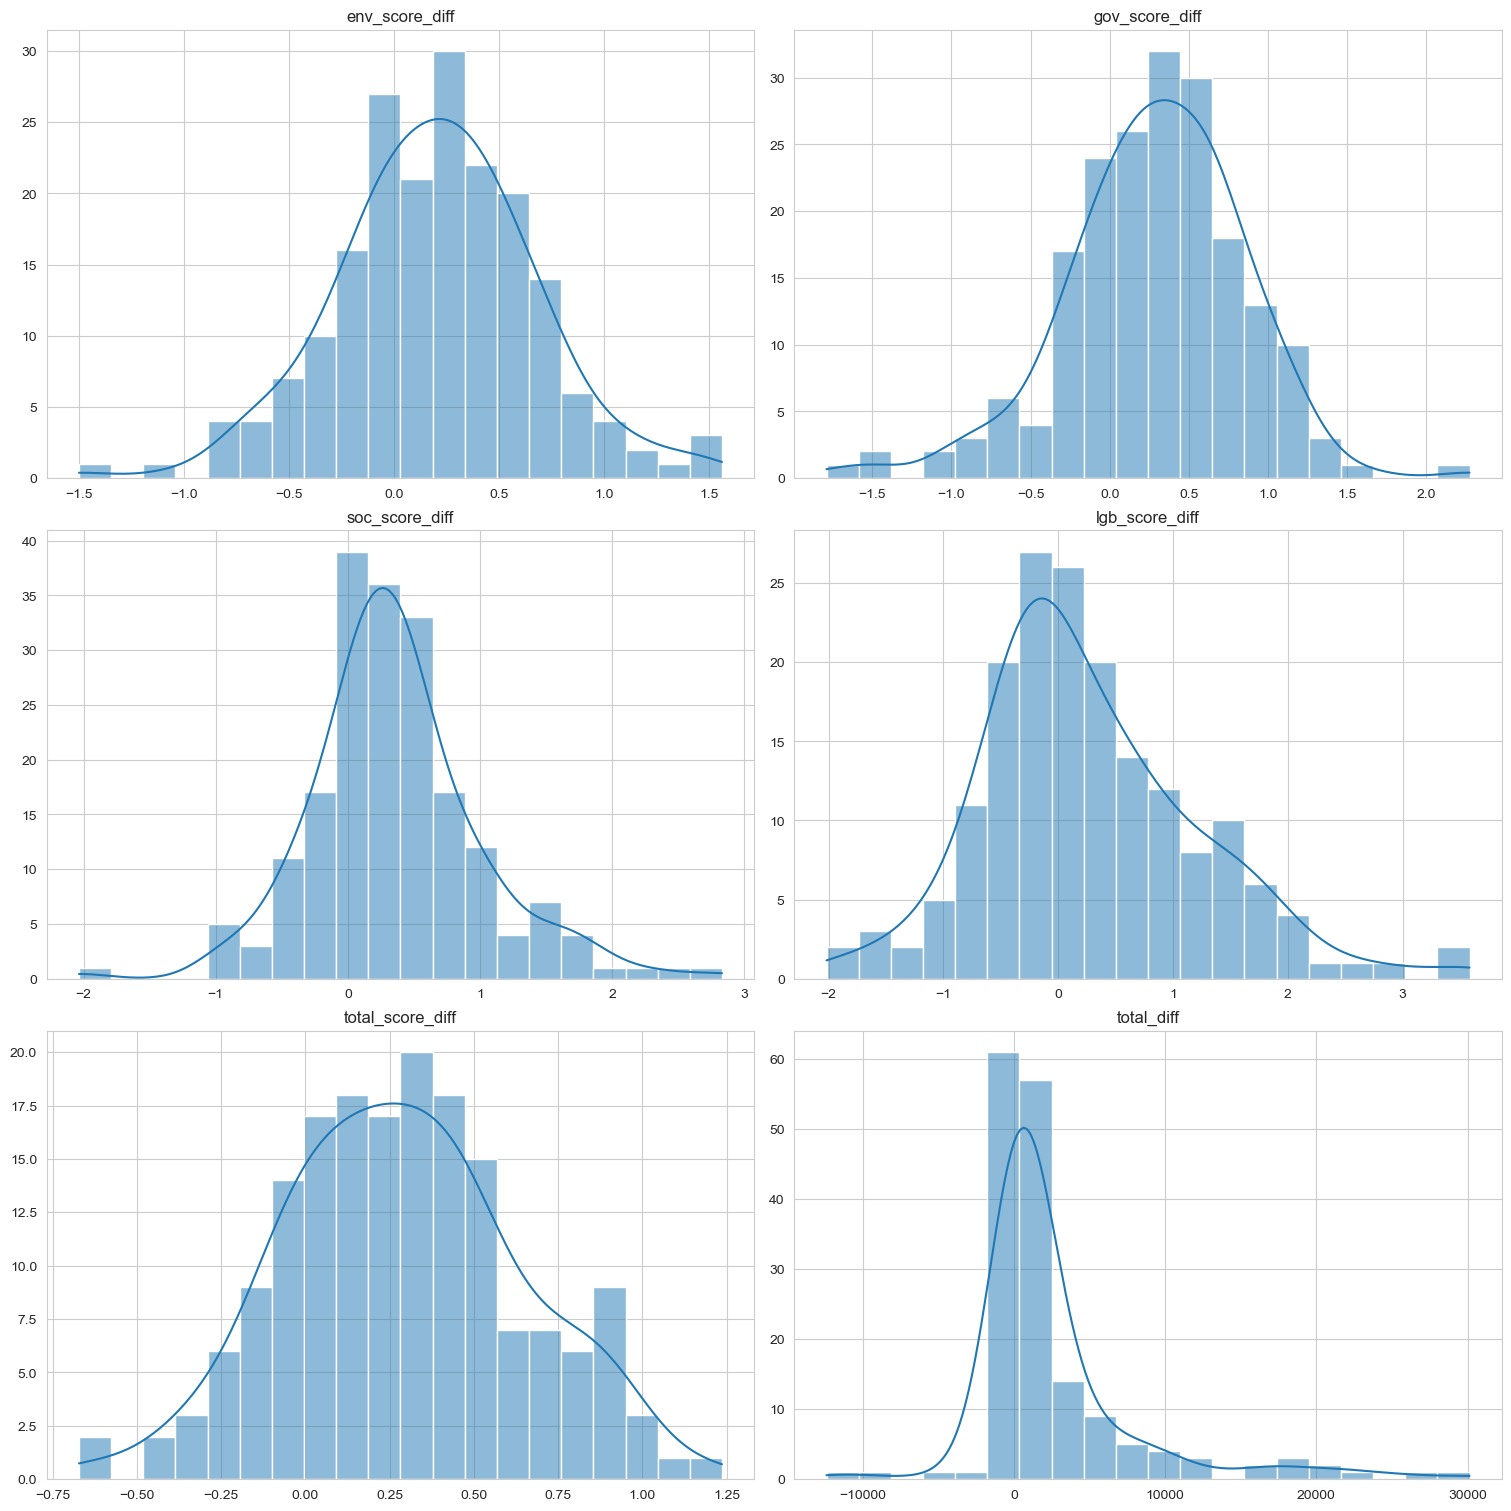

In [150]:
num_col = ['env_score_diff', 'gov_score_diff', 'soc_score_diff', 'lgb_score_diff', 'total_score_diff', 'total_diff']
rows, cols = 3, 2
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in num_col:
    plt.subplot(rows, cols, counter)
    sns.histplot(data =df_analysis_diff, x= i, bins=20, kde=True)
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

In [151]:
# Apply logarithmic transformation to the travel data
df_log_diff = df_analysis_diff.copy()
colum_to_log = ['total_diff']
df_log_diff[colum_to_log] = df_log_diff[colum_to_log].apply(lambda x: np.log(x))

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


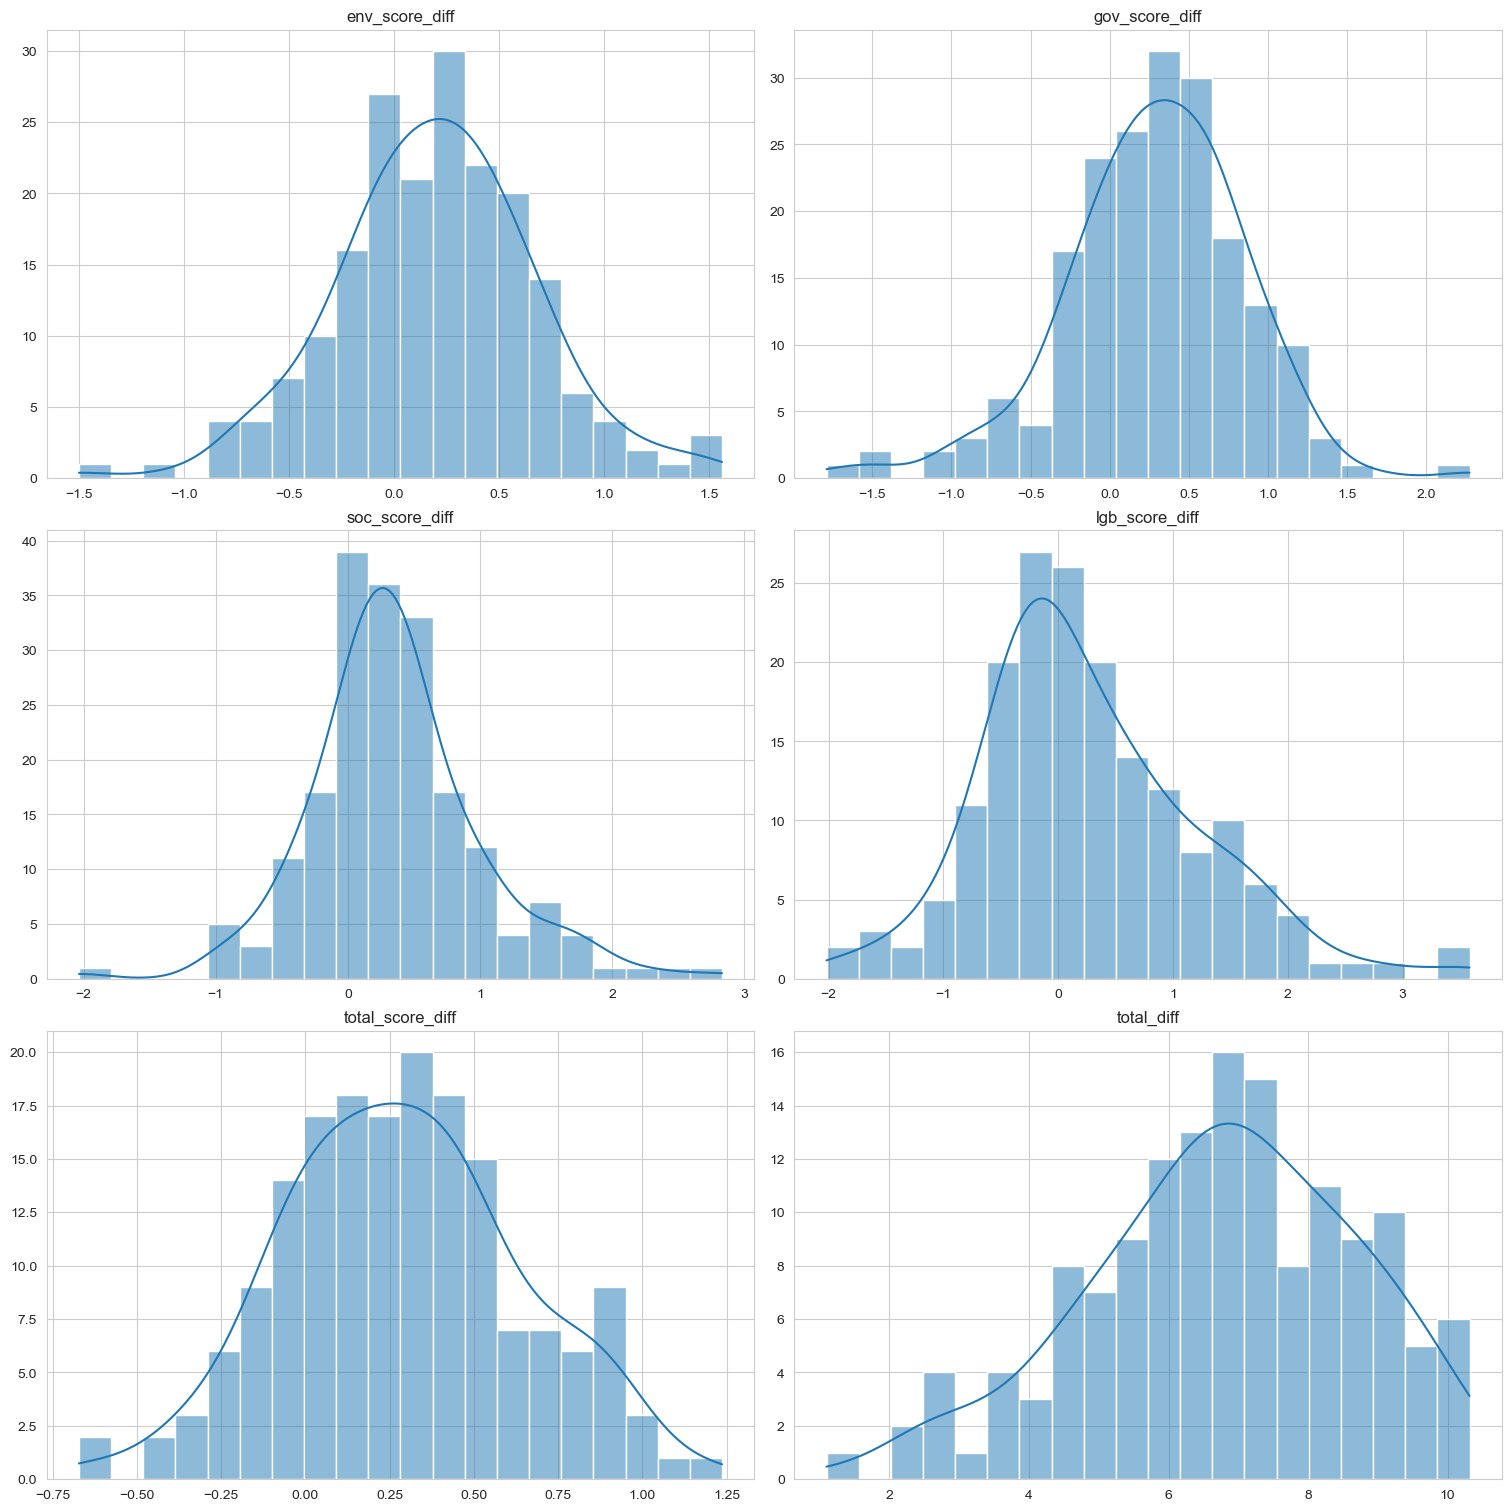

In [152]:
num_col = ['env_score_diff', 'gov_score_diff', 'soc_score_diff', 'lgb_score_diff', 'total_score_diff', 'total_diff']
rows, cols = 3, 2
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in num_col:
    plt.subplot(rows, cols, counter)
    sns.histplot(data = df_log_diff, x= i, bins=20, kde=True)
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

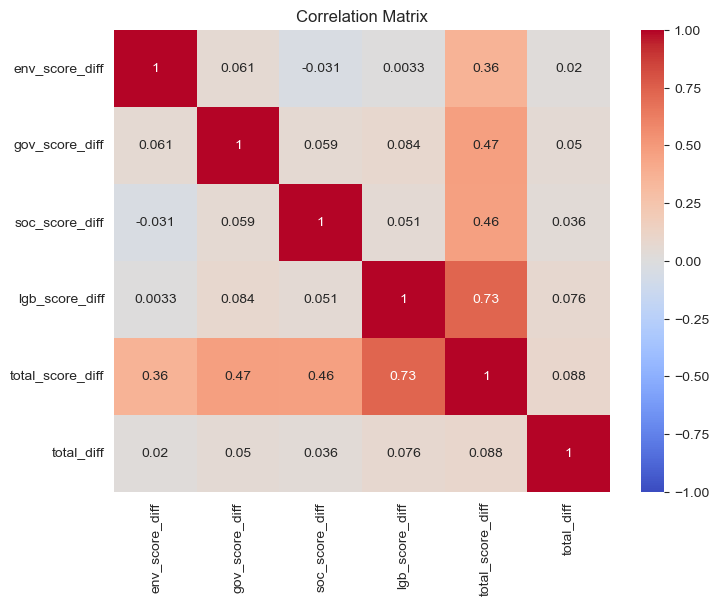

In [153]:
# Compute the correlation matrix
corr_matrix_diff = df_analysis_diff[['env_score_diff', 'gov_score_diff', 'soc_score_diff', 'lgb_score_diff', 'total_score_diff', 'total_diff']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_diff, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

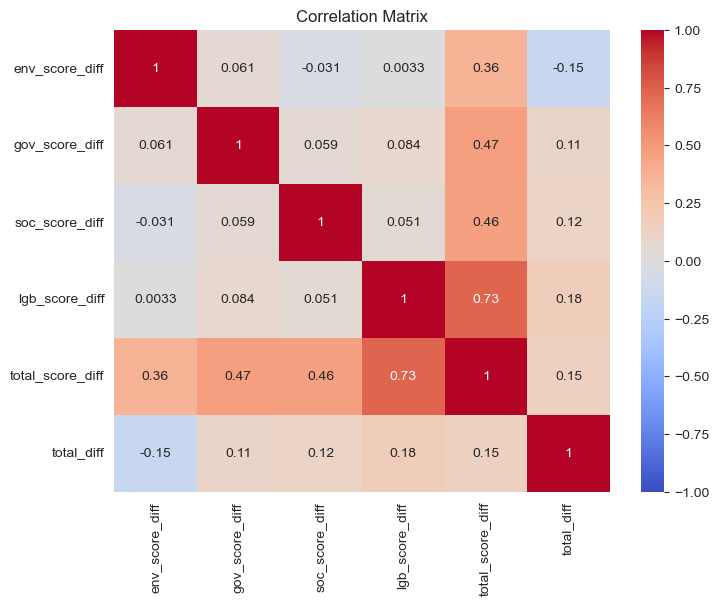

In [154]:
# Compute the correlation matrix
corr_matrix_diff = df_log_diff[['env_score_diff', 'gov_score_diff', 'soc_score_diff', 'lgb_score_diff', 'total_score_diff', 'total_diff']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_diff, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()